In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results

#uncomment to direct the print standard output to the outputfile.txt
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")

In [13]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATETIME>,,,,,,,
2000-01-03 00:00:00,1.4463,1.4465,1.4450,1.4451,32,0,50
2000-01-03 03:00:00,1.4445,1.4459,1.4445,1.4451,54,0,50
2000-01-03 06:00:00,1.4452,1.4485,1.4450,1.4466,171,0,50
2000-01-03 09:00:00,1.4467,1.4475,1.4438,1.4440,489,0,50
2000-01-03 12:00:00,1.4444,1.4457,1.4407,1.4415,608,0,50


In [14]:
#build window features, assuming we know today's open. Include fillna(0)

for n in list(range(1,21)):
    name = f'ret{str(n)}'
    df[name] = df["<OPEN>"].pct_change(periods=n).fillna(0)



In [15]:
#build date-time features
df["hour"] = df.index.hour
df["day"] = df.index.dayofweek  # 0=Monday, 6=Sunday

df[['hour','day']].head()

,hour,day
<DATETIME>,,
2000-01-03 00:00:00,0,0
2000-01-03 03:00:00,3,0
2000-01-03 06:00:00,6,0
2000-01-03 09:00:00,9,0
2000-01-03 12:00:00,12,0


In [20]:
df_dummies_hour = pd.get_dummies(df["hour"], prefix='hour')
df_dummies_day = pd.get_dummies(df["day"], prefix='day')

# make sure the new cols not exist yet
df = df.drop(columns=df_dummies_hour.columns, errors='ignore')
df = df.drop(columns=df_dummies_day.columns, errors='ignore')

df = df.join(df_dummies_hour)
df = df.join(df_dummies_day)

print(len(df.columns))
df.columns

43


Index(['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>',
       '<SPREAD>', 'ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6', 'ret7',
       'ret8', 'ret9', 'ret10', 'ret11', 'ret12', 'ret13', 'ret14', 'ret15',
       'ret16', 'ret17', 'ret18', 'ret19', 'ret20', 'hour', 'day', 'hour_0',
       'hour_3', 'hour_6', 'hour_9', 'hour_12', 'hour_15', 'hour_18',
       'hour_21', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5'],
      dtype='object')

In [23]:
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
df[['<OPEN>','retFut1']].tail()

,<OPEN>,retFut1
<DATETIME>,,
2021-07-20 06:00:00,1.27422,0.002142
2021-07-20 09:00:00,1.27695,-0.001300
2021-07-20 12:00:00,1.27529,-0.000267
2021-07-20 15:00:00,1.27495,-0.000612
2021-07-20 18:00:00,1.27417,0.000000


In [24]:
#transform the target
df['retFut1_categ'] =  np.where(df['retFut1'] > 0, 1, 0)  
        
#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ',"hour","day"], axis=1) #these drops are note optional, why?
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

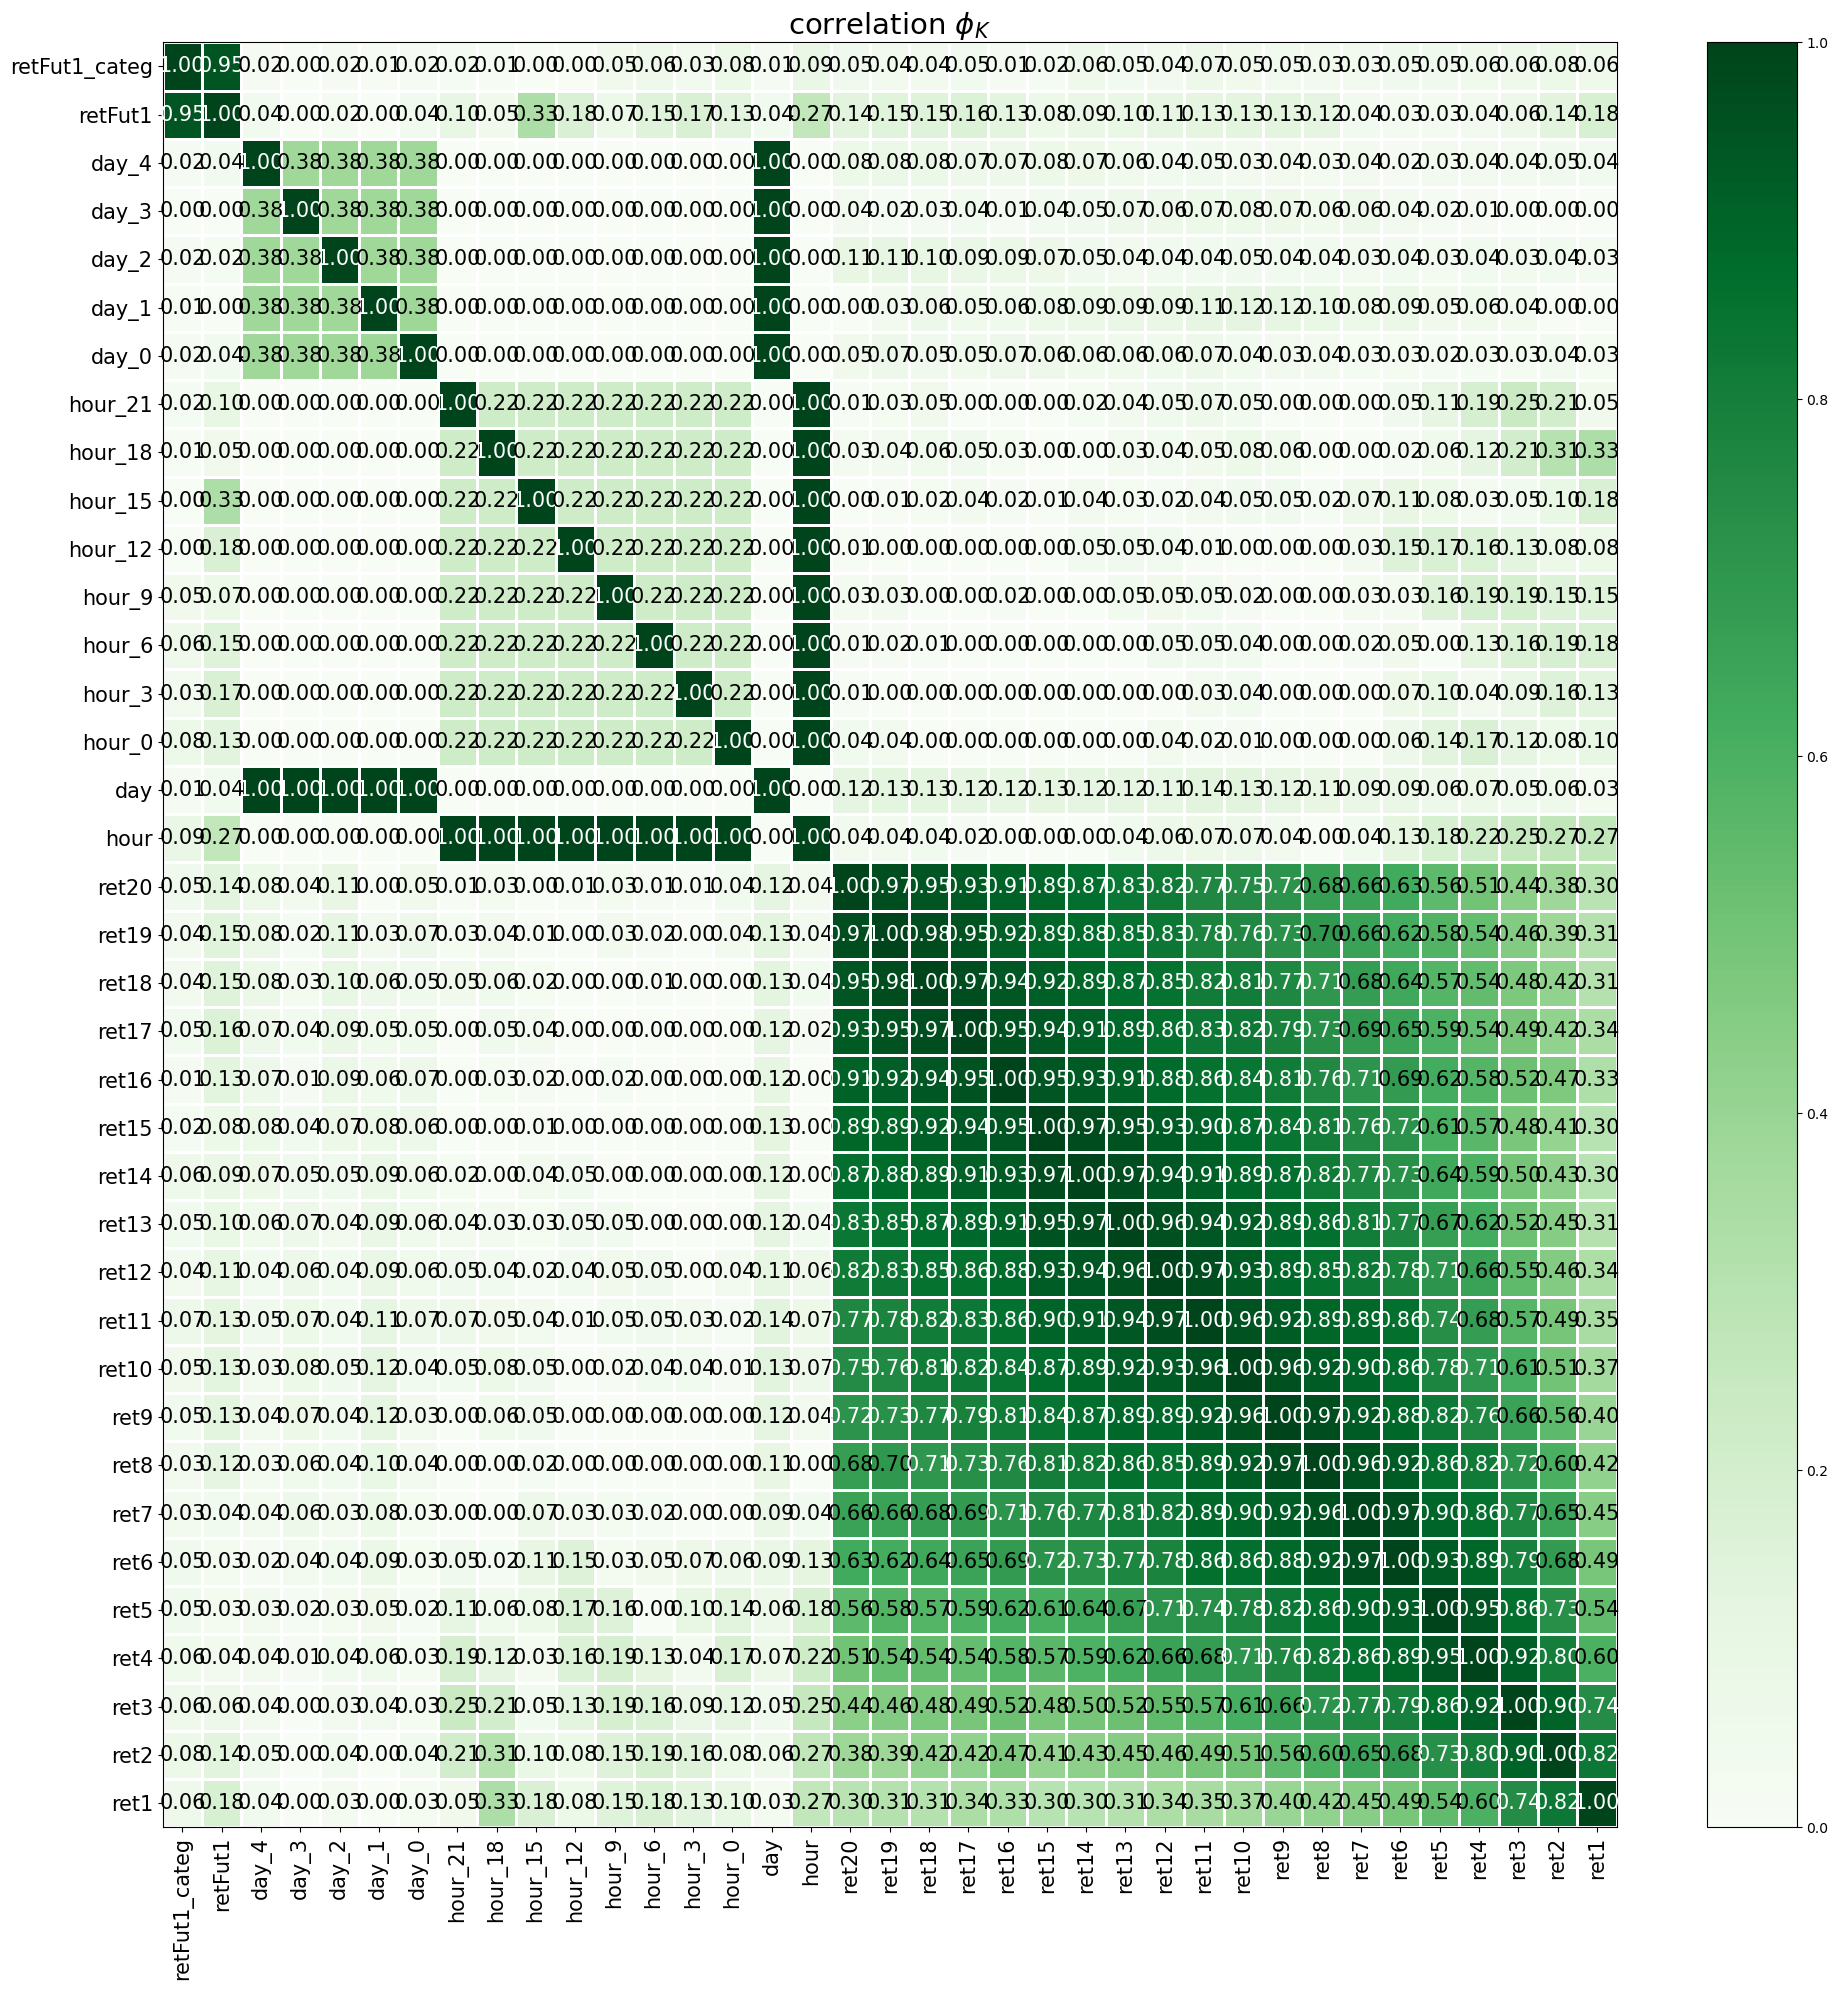

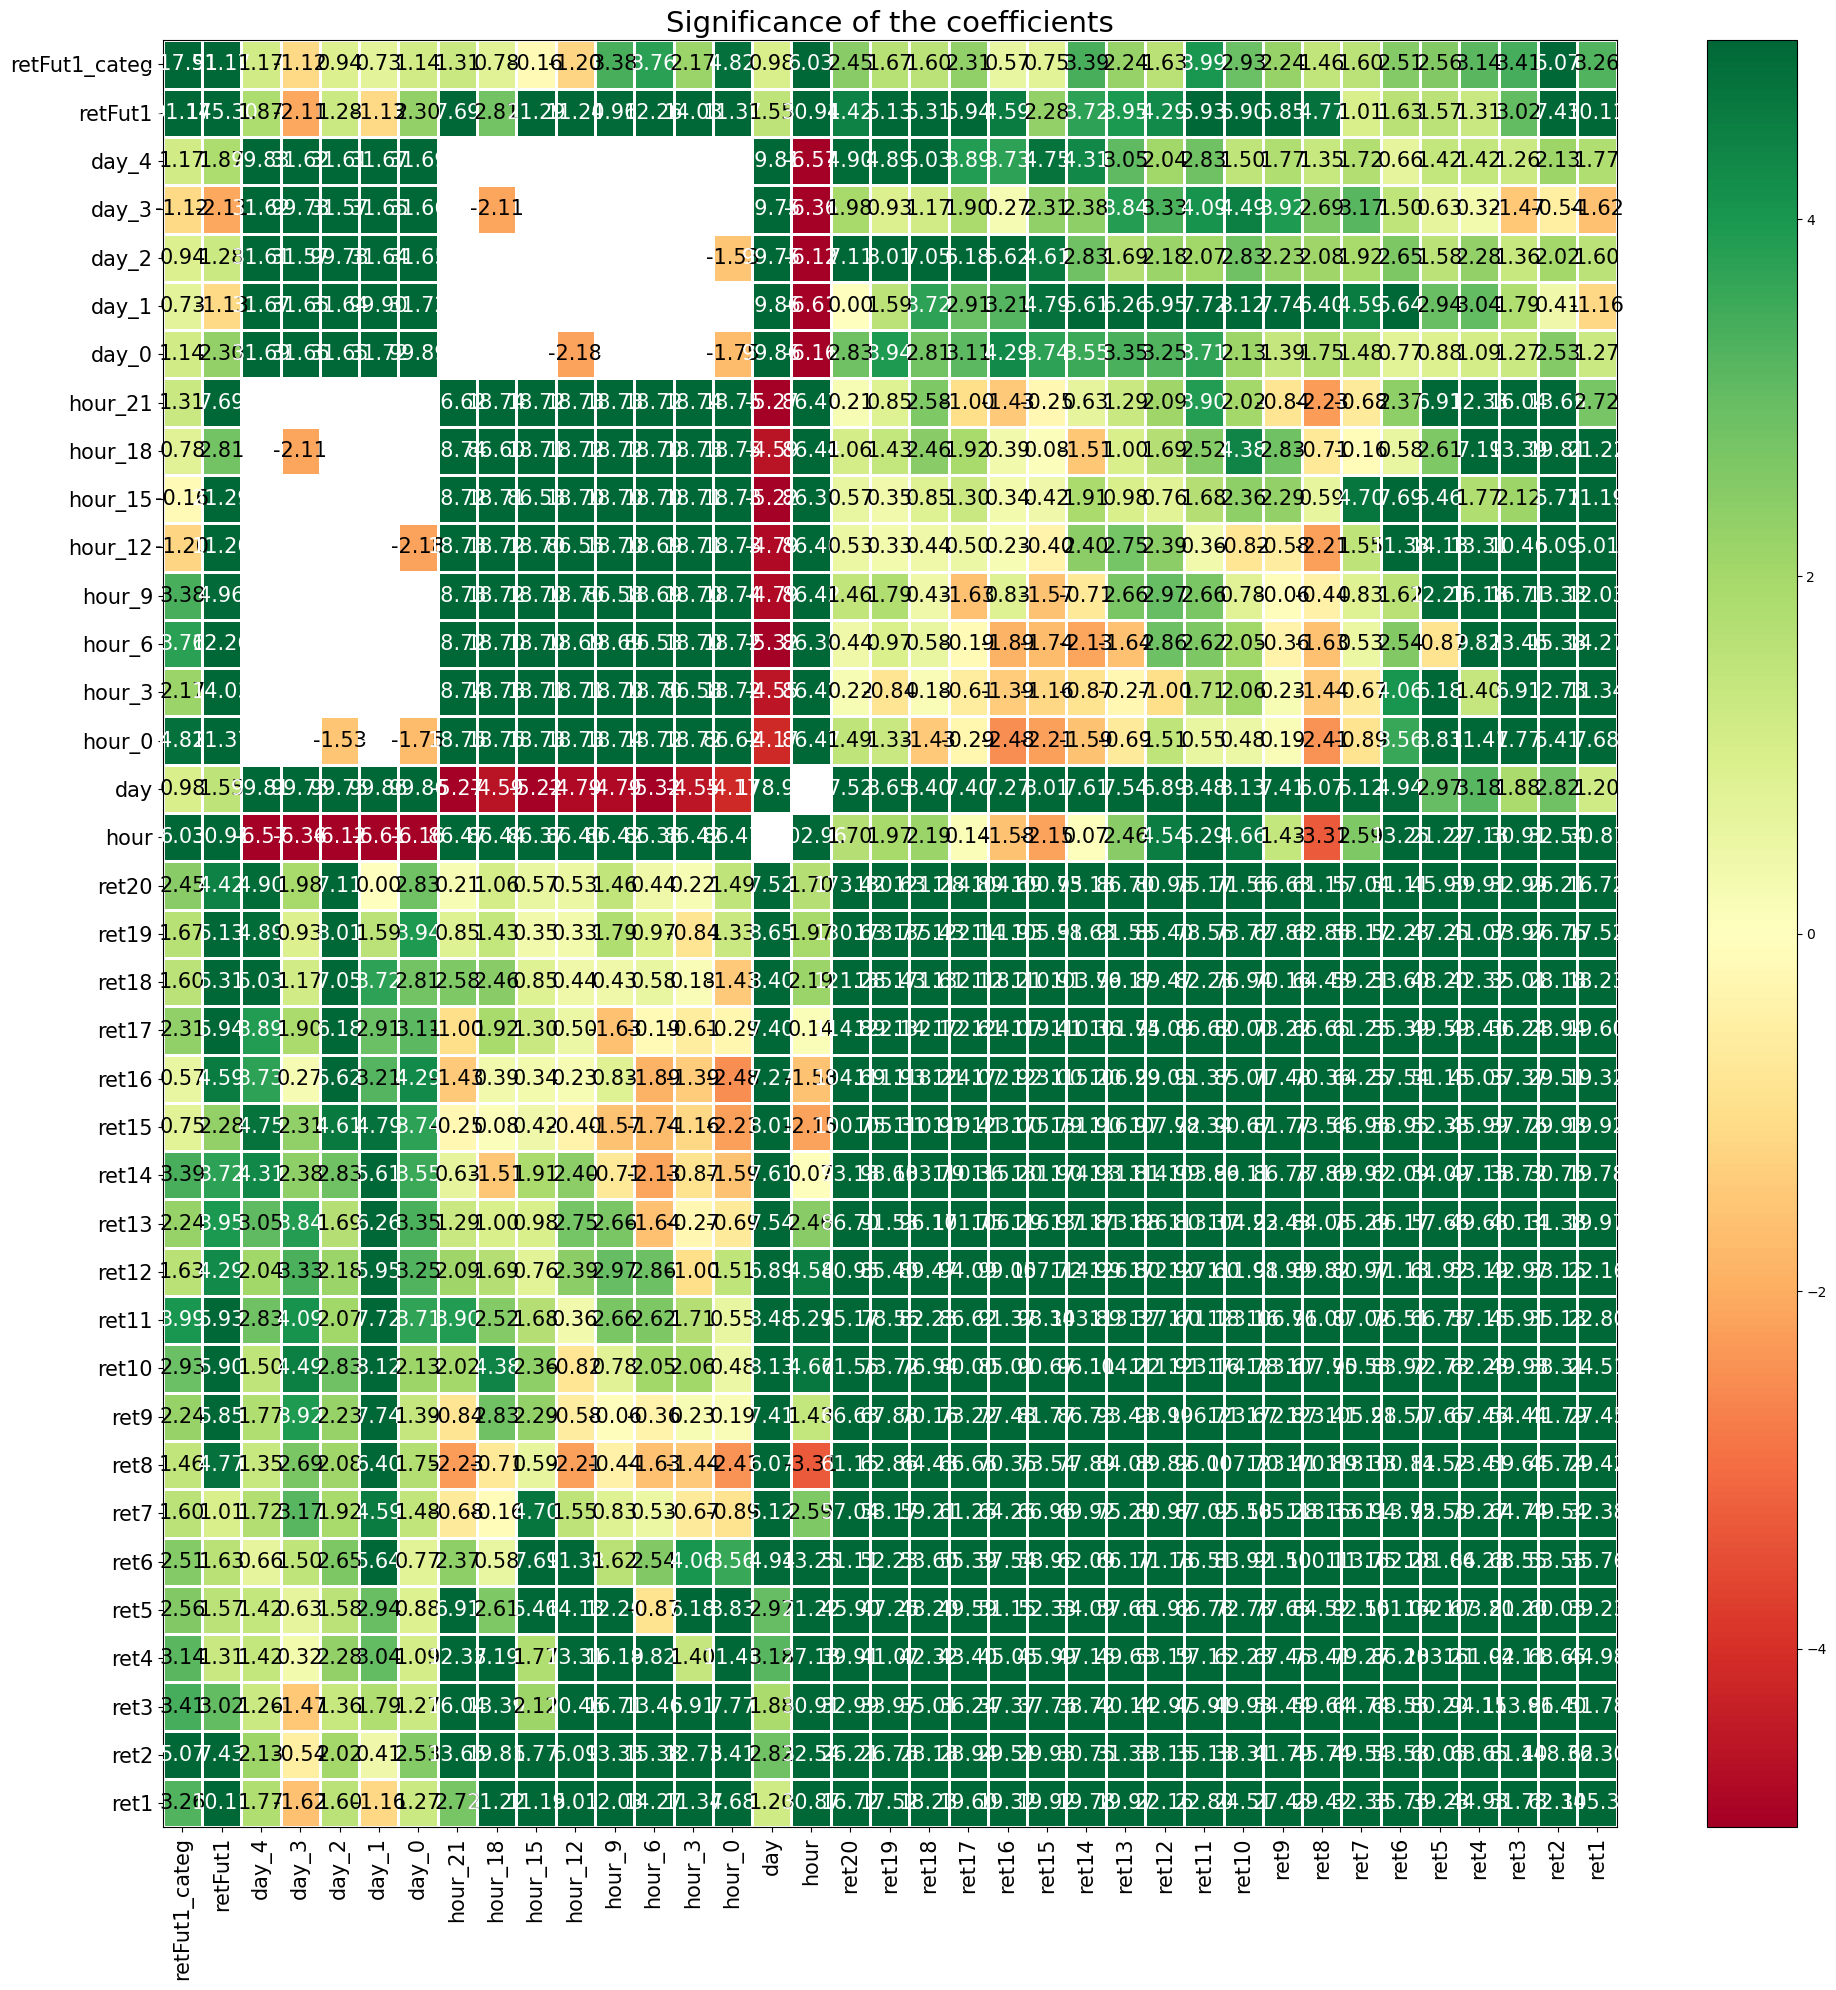

In [25]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

#list of continuous numerical variables
interval_cols = df_train.select_dtypes(include=['float64']).columns.values.tolist()
#Plot the correlation matrix containing the pair-wise phik coefficients
phik_overview = df_train.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("Correlation Matrix"))

#Plot the  significances of the above phik correlations
#this is optional because we have lots of data. 
#You want to see significances colored in dark green, which are the highest significances.
significance_overview = df_train.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 20))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("Correlation Matrix Significance"))

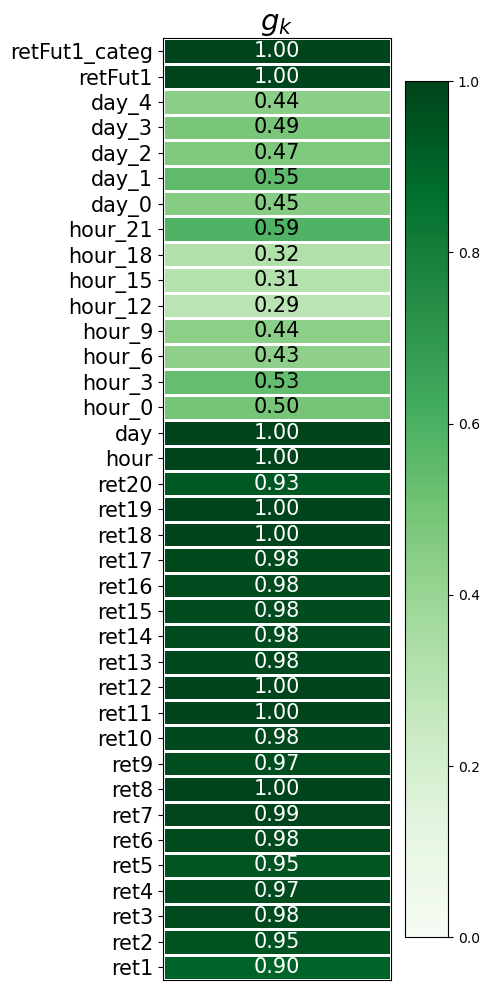

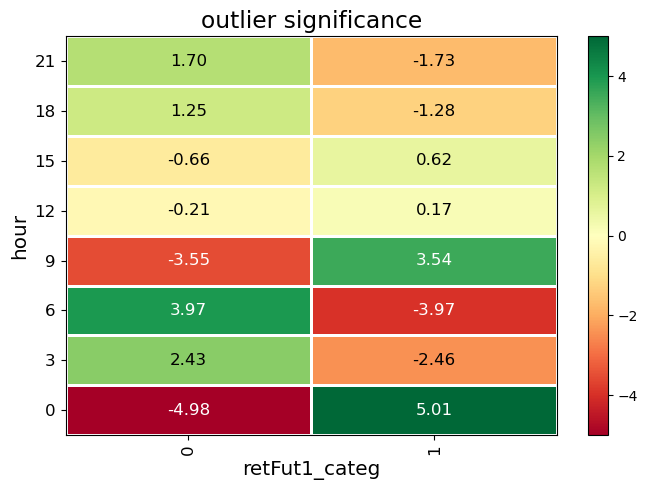

<Figure size 640x480 with 0 Axes>

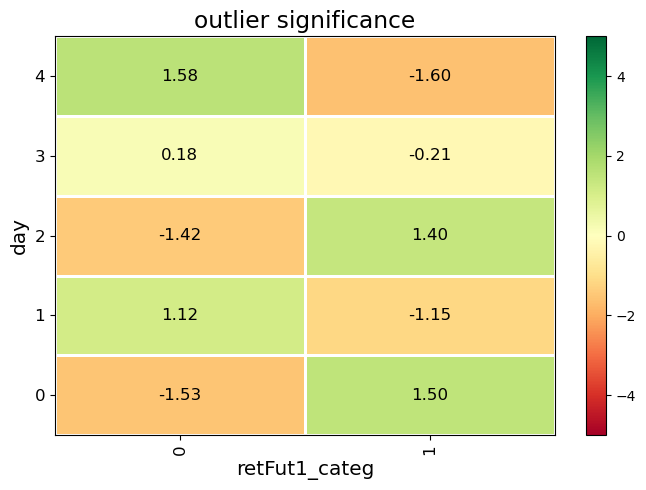

interval columns not set, guessing: ['ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6', 'ret7', 'ret8', 'ret9', 'ret10', 'ret11', 'ret12', 'ret13', 'ret14', 'ret15', 'ret16', 'ret17', 'ret18', 'ret19', 'ret20', 'hour', 'day', 'retFut1', 'retFut1_categ']
(                   ret1      ret2      ret3      ret4      ret5      ret6  \
ret1           1.000000  0.824266  0.743539  0.598263  0.543708  0.489791   
ret2           0.824266  1.000000  0.900086  0.803172  0.731976  0.683860   
ret3           0.743539  0.900086  1.000000  0.917504  0.861344  0.792626   
ret4           0.598263  0.803172  0.917504  1.000000  0.946079  0.892932   
ret5           0.543708  0.731976  0.861344  0.946079  1.000000  0.928815   
ret6           0.489791  0.683860  0.792626  0.892932  0.928815  1.000000   
ret7           0.448923  0.648785  0.769454  0.859272  0.896699  0.971552   
ret8           0.415961  0.601842  0.715845  0.816504  0.858866  0.923209   
ret9           0.397475  0.557270  0.656865  0.763167  

In [27]:
#The global correlation coefficient is a useful measure expressing the total correlation 
#of one variable to all other variables in the dataset. 
#This gives us an indication of how well one variable can be modeled 
#using the other variables.

global_correlation, global_labels = df_train.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(5,10),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("Global Correlations"))

#the outlier significance matrix helps us understand better the phik correlation 
#between categorical and continuous variables and 
#between categorical and categorical variables.

var_1 = "hour" 
var_2 = "retFut1_categ"

outlier_signifs, binning_dict = df_train[[var_1, var_2]].outlier_significance_matrix(interval_cols=[], 
                                                                        retbins=True)

zvalues = outlier_signifs.values
xlabels = outlier_signifs.columns
ylabels = outlier_signifs.index

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=var_2,y_label=var_1,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, 
                        figsize=(7, 5))
plt.show()
plt.savefig(r'Results\%s.png' %("Outlier Significance Matrix for Hour"))

var_1 = "day"
var_2 = "retFut1_categ"

outlier_signifs, binning_dict = df_train[[var_1, var_2]].outlier_significance_matrix(interval_cols=[], 
                                                                        retbins=True)

zvalues = outlier_signifs.values
xlabels = outlier_signifs.columns
ylabels = outlier_signifs.index

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=var_2,y_label=var_1,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, 
                        figsize=(7, 5))

plt.show()
plt.savefig(r'Results\%s.png' %("Outlier Significance Matrix for Day"))

#a convenience function that allows us to generate all of the above with a single line of code:
rep = report.correlation_report(df_train, significance_threshold=3, correlation_threshold=0.5)
print(rep)

plt.close("all")

### RESULTS  
If you look at the Phik correlation between each of the 21 retNs and retFut1_categ   
it is possible to identify a subset of 6 retNs that are the best ones.  
Run the model with this subset of 6 retNs and  
the results of the logistic regression will be better.   

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
from sklearn import preprocessing
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer


In [29]:
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_corr)
    return phi_k_corr

In [30]:
#myscorerNone = None #use default accuracy score
myscorerPhik = make_scorer(phi_k, greater_is_better=True)

imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
scaler = StandardScaler(with_mean=False, with_std=False)
logistic = LogisticRegression(max_iter=1000, solver='liblinear') 

pipe = Pipeline([("imputer", imputer),("scaler", scaler), ("logistic", logistic)])

In [32]:
c_rs = np.logspace(3, -4, 20)
print(c_rs)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]

param_grid =  [{'logistic__C': c_rs, 'logistic__penalty': p_rs}]

[1.00000000e+03 4.28133240e+02 1.83298071e+02 7.84759970e+01
 3.35981829e+01 1.43844989e+01 6.15848211e+00 2.63665090e+00
 1.12883789e+00 4.83293024e-01 2.06913808e-01 8.85866790e-02
 3.79269019e-02 1.62377674e-02 6.95192796e-03 2.97635144e-03
 1.27427499e-03 5.45559478e-04 2.33572147e-04 1.00000000e-04]


In [33]:
grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorerPhik, return_train_score=True) #####
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=*, return_train_score=True) #####

grid_search.fit(x_train.values, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

print(results.T)
results.to_csv("results_logisticreg.csv")


0.08949215916928785
0.1588233179518511
0.08175631437979669
0.16055754347124945
0.10526590822845773
0.1546578469407241
0.1238472916023189
0.14117700735177183
0.10860282023537157
0.16292616848443783
0.05102145754643638
0.10819932011412017
0.0605136987882326
0.113314774971974
0.07330830947668635
0.10940887259737708
0.05077484805229597
0.11142188337274075
0.08198354616265471
0.09897296786135613
0.0648979477477962
0.14349905297109153
0.09122356848650848
0.15097939123143594
0.10486532515090217
0.15267648802824982
0.1182188173428408
0.1294381849589672
0.10495194515912491
0.1729422744138234
0.07332328012629032
0.1089201588270878
0.034456725010379864
0.12709938844927754
0.07915885052491935
0.1167399140645054
0.083174399081531
0.10544291092966021
0.09224109979753008
0.11317269732567188
0.07667599545908198
0.10452537777799788
0.03670327755009355
0.12579861579440957
0.07261338159718729
0.10208909221365776
0.08244189076118512
0.10076453109062876
0.09582918469146093
0.1123708410136599
0.076675995459

In-sample: CAGR=0.0319928 Sharpe ratio=1.25014 maxDD=-0.0697507 maxDDD=538 Calmar ratio=0.458673



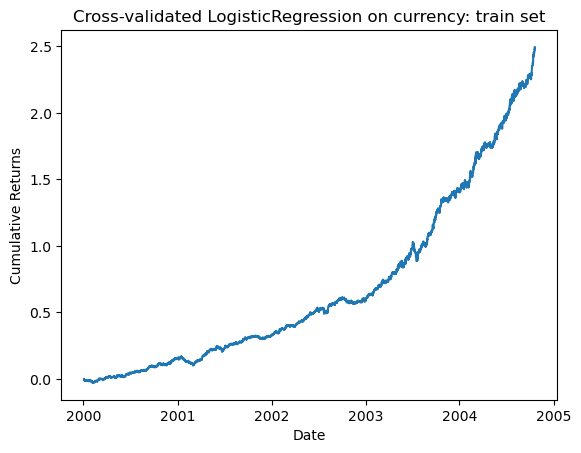

In [39]:
# Train Set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train.values)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) #POSITIONS

dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open
dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))

cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

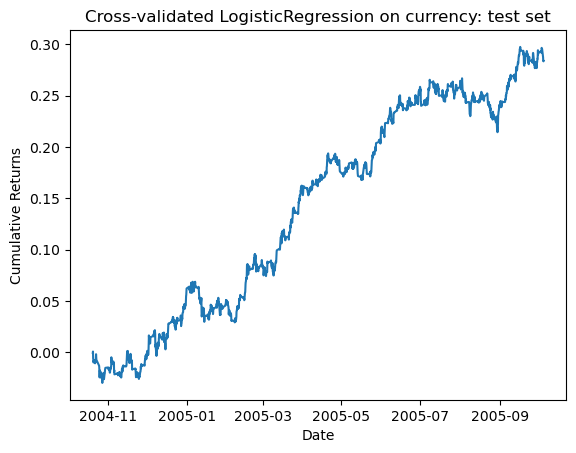

In [40]:
# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test.values)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 ) #POSITIONS

dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated LogisticRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative2"))


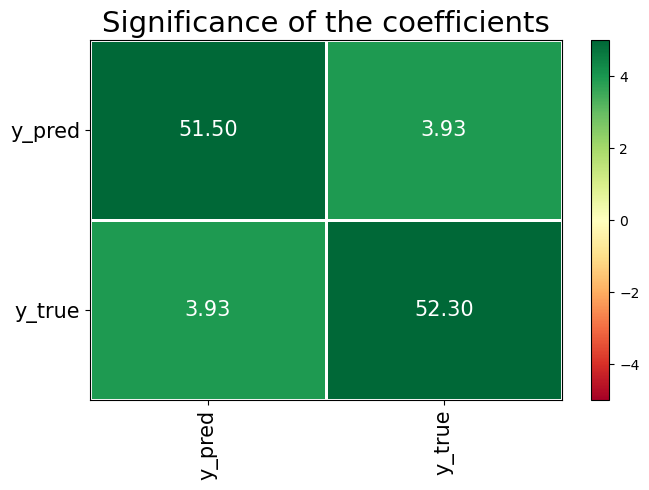

Out-of-sample: CAGR=0.0319953 Sharpe ratio=0.987511 maxDD=-0.0414377 maxDDD=218 Calmar ratio=0.772131  phi_k_corr=0.13755 phi_k_p_val=4.98941e-05  accuracy_score=0.5475



<Figure size 640x480 with 0 Axes>

In [45]:
#metrics
# del accuracy_score
# from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test.values))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test.values)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
plt.show()
plt.savefig(r'Results\%s.png' %("Significance2"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, acc))


In [48]:
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

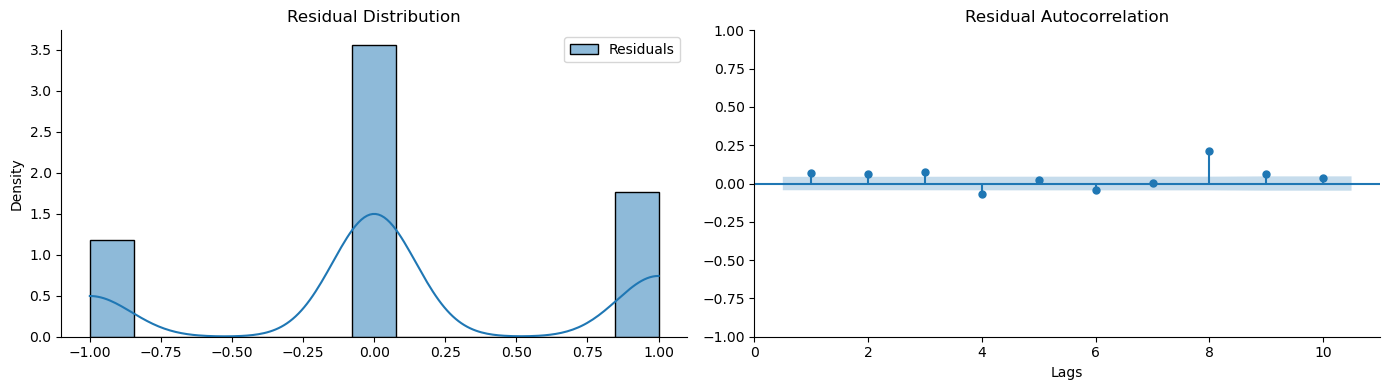

In [51]:
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(residuals, kde=True, stat="density", ax=axes[0], label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
plt.show()
plt.savefig(r'Results\%s.png' %("Residuals2"))
plt.close("all")



In [57]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb['lb_pvalue'])
# print(lb)

Ljung-Box test p-value 10    2.101062e-26
Name: lb_pvalue, dtype: float64


array([[0.53348957, 0.46651043],
       [0.54891434, 0.45108566],
       [0.4727655 , 0.5272345 ],
       ...,
       [0.54602397, 0.45397603],
       [0.552353  , 0.447647  ],
       [0.46615459, 0.53384541]])

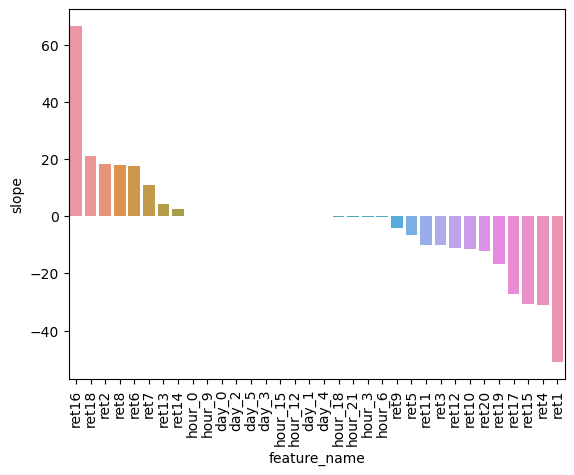

In [58]:
#plot the coefficients
importance = pd.DataFrame(zip(best_model[2].coef_.ravel().tolist(), x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients2"))

#In the future, you may need a classifier's continuous predictions, 
#especially when using the Alphalens evaluator, later on in the course, where
#you can use a model's predictions as input
#You can construct the classifier's continuous predictions 
#from the prediction probabilities obtained from the model's predict_proba method:

logistic = LogisticRegression(max_iter=1000, solver='liblinear') 
logistic.fit(x_train, y_train)
pred_proba = logistic.predict_proba(x_test) #compare with pred_categ = logistic.predict(x_test)
df = pd.DataFrame(pred_proba, columns=["downs","ups"])
df["continuous_predictions"] = np.where(df["ups"]>df["downs"], df["ups"], -1*df["downs"])

#Not all scikit-learn classifiers have a predict_proba method.
#If your classifier lacks a predict-proba method, 
#you can use the following scikit-learn classifier wrapper:

from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(logistic) 
model.fit(x_train, y_train)
pred_class = model.predict(x_test)
model.predict_proba(x_test)
